<a href="https://colab.research.google.com/github/syadav4320/Image-Multi-Classification-and-N-similarity/blob/main/similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install livelossplot

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import requests
# import splitfolders
import tensorflow as tf
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,UpSampling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
from tqdm import tqdm
from tensorflow.keras import backend as K
import cv2
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data generator for training set
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2, # random application of shearing
    # zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

# data generator for test set
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:

train_generator = train_datagen.flow_from_directory(
    r'/content/drive/MyDrive/ML/Eyewear/eye1/train',
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1000,
    class_mode = 'categorical',
    shuffle=True,
    seed=40)

# generator for reading validation data from folder
validation_generator = test_datagen.flow_from_directory(
    r'/content/drive/MyDrive/ML/Eyewear/eye1/val',
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 200,
    class_mode = 'categorical',
    shuffle=True,
    seed=40)

# generator for reading test data from folder
test_generator = test_datagen.flow_from_directory(
    r'/content/drive/MyDrive/ML/Eyewear/eye1/test',
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 50,
    class_mode = 'categorical',
    shuffle = False
    )


In [ ]:

def encoder_decoder_model():

  #Encoder 
  model = Sequential(name='Convolutional_AutoEncoder_Model')
  model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(224, 224, 3),padding='same', name='Encoding_Conv2D_1'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_1'))
  model.add(Conv2D(128, kernel_size=(3, 3),strides=1,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu',padding='same', name='Encoding_Conv2D_2'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_2'))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_3'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_3'))
  model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_4'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid', name='Encoding_MaxPooling2D_4'))
  model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv2D_5'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
    
  #Decoder
  model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu', padding='same', name='Decoding_Conv2D_1'))
  model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_1'))
  model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same', name='Decoding_Conv2D_2'))
  model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_2'))
  model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same',name='Decoding_Conv2D_3'))
  model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_3'))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_4'))
  model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_4'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_5'))
  model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_5'))
  model.add(Conv2D(3, kernel_size=(3, 3), padding='same',activation='sigmoid',name='Decoding_Output'))
  return model
    
model = encoder_decoder_model()
model.summary()

Model: "Convolutional_AutoEncoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding_Conv2D_1 (Conv2D)   (None, 224, 224, 64)      1792      
_________________________________________________________________
Encoding_MaxPooling2D_1 (Max (None, 112, 112, 64)      0         
_________________________________________________________________
Encoding_Conv2D_2 (Conv2D)   (None, 112, 112, 128)     73856     
_________________________________________________________________
Encoding_MaxPooling2D_2 (Max (None, 56, 56, 128)       0         
_________________________________________________________________
Encoding_Conv2D_3 (Conv2D)   (None, 56, 56, 256)       295168    
_________________________________________________________________
Encoding_MaxPooling2D_3 (Max (None, 28, 28, 256)       0         
_________________________________________________________________
Encoding_Conv2D_4 (Conv2D)   (None,

In [ ]:

# n_steps =len(train_generator.filenames) // batch_size
# n_val_steps = len(validation_generator.filenames)// batch_size
# n_epochs = 50

In [ ]:
optimizer = Adam(learning_rate=0.001) 
model = encoder_decoder_model() 
model.compile(optimizer=optimizer, loss='mse') 
plot_loss_1 = PlotLossesCallback()
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=6,min_delta=0.0001) 
checkpoint = ModelCheckpoint(r'/content/drive/MyDrive/ML/Eyewear/encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 
model.fit(train_generator,
          batch_size=batch_size,
          epochs=n_epochs,
          validation_data=validation_generator,
          steps_per_epoch=n_steps,
          validation_steps=n_val_steps,
          callbacks=[early_stopping,checkpoint,plot_loss_1]) 


In [ ]:
# File path
filepath = r'/content/drive/MyDrive/ML/Eyewear/encoder_model.h5'

# Load the model
model = tf.keras.models.load_model(filepath, compile = True)

In [ ]:

# def image2array(file_array):

#     image_array = []
#     for path in tqdm(file_array):
#         img = cv2.imread(path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (224,224))
#         image_array =np.append(image_array,np.array(img))
#         image_array = np.array(image_array)
#         image_array = image_array.reshape(image_array.shape[0], 224, 224, 3)
#         image_array = image_array.astype('float32')
#         image_array /= 255
#     return np.array(image_array)

# train_data = image2array(total_train)
# print("Length of training dataset:",train_data.shape)
# test_data = image2array(test_generator.filepaths)
# print("Length of test dataset:",test_data.shape)

In [ ]:
# img_width, img_height, channels = 224, 224, 3
# input_shape = (img_width, img_height, channels)

# def load_data(files):
#     arr = np.empty((len(files), img_width, img_height, channels), dtype=np.float32)
#     for i, imgfile in enumerate(files):
#         img = tf.keras.utils.load_img(imgfile)
#         x = tf.keras.utils.img_to_array(img).reshape(img_width, img_height, channels)
#         x = x.astype('float32') / 255.
#         arr[i] = x
#     return arr

# X_train = load_data(files=total_train)

In [ ]:
x_train = next(train_generator)[0]
x_test = next(test_generator)[0]

In [ ]:
# x_train,y_train = next(train_generator)
# x_val,y_val = next(validation_generator)
# x_test,y_test = next(test_generator)

In [ ]:
# total_train = np.append(x_train,x_val,axis=0)


In [ ]:
# del y_train
# del y_val
# del y_test

In [ ]:
x_train.shape

(1000, 224, 224, 3)

Before autoencoding:


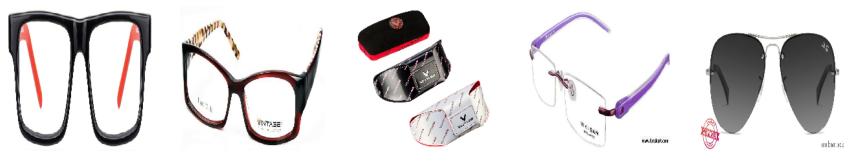

After decoding:


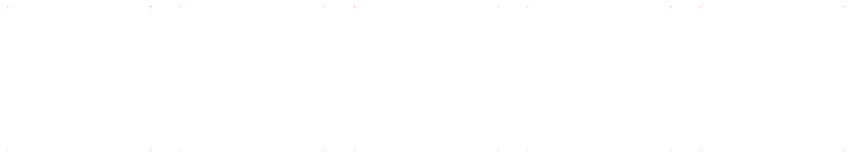

In [ ]:
def plot_some(im_list):
    plt.figure(figsize=(15,4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i+1)
        plt.imshow(array)
        plt.axis('off')
    plt.show()

img_decoded = model.predict(x_train[:5])

print('Before autoencoding:')
plot_some(x_train[:5])
print('After decoding:')
plot_some(img_decoded)

In [ ]:
x_train.dtype

dtype('float32')

In [ ]:
X_sample = x_train[:5]
print(X_sample.shape)

get_encoded = K.function([model.layers[0].input], [model.layers[5].output])
encoded_sample = get_encoded([X_sample])[0]
print(encoded_sample.shape)

(5, 224, 224, 3)
(5, 28, 28, 256)


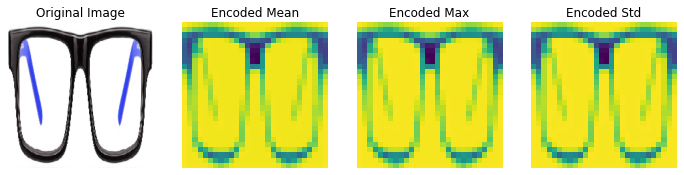

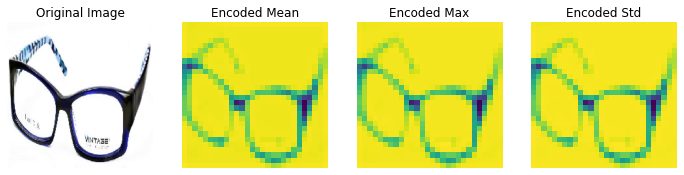

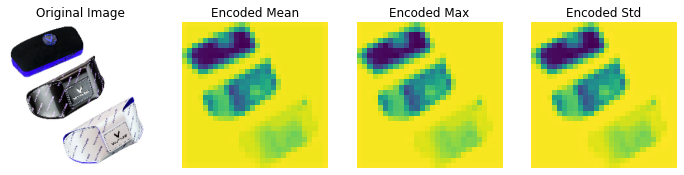

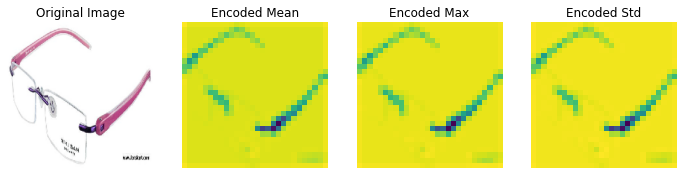

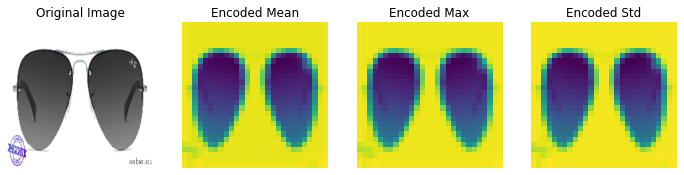

In [ ]:
for n_image in range(0, 5):
    
    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.imshow(X_sample[n_image][:,:,::-1])
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(encoded_sample[n_image].mean(axis=-1))
    plt.axis('off')
    plt.title('Encoded Mean')

    plt.subplot(1,4,3)
    plt.imshow(encoded_sample[n_image].max(axis=-1))
    plt.axis('off')
    plt.title('Encoded Max')

    plt.subplot(1,4,4)
    plt.imshow(encoded_sample[n_image].std(axis=-1))
    plt.axis('off')
    plt.title('Encoded Std')

    plt.show()

In [ ]:
X_encoded = np.empty((len(x_train), 28, 28, 256), dtype='float32')

step = 1
for i in range(0, len(x_train), step):
    x_batch = get_encoded([total_train[i:i+step]])[0]
    X_encoded[i:i+step] = x_batch

print(X_encoded.shape)

(1000, 28, 28, 256)


In [ ]:
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2]*X_encoded.shape[3])
print(X_encoded_reshape.shape)

(1000, 200704)


In [ ]:
#dimensionality reduction for visualization
transform = TSNE 
trans = transform(n_components=2) 
values = trans.fit_transform(X_encoded_reshape) 


if Number of clusters: 5


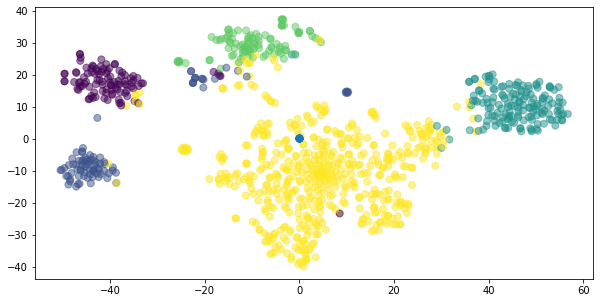

<Figure size 936x216 with 0 Axes>

<Figure size 936x216 with 0 Axes>

<Figure size 936x216 with 0 Axes>

<Figure size 936x216 with 0 Axes>

<Figure size 936x216 with 0 Axes>

In [ ]:

# K = [3,4,5,6] #hyper parameter tuning
K=[5]
for k in K:
    print("if Number of clusters: "+str(k))
    # clustering the data
    kmeans = KMeans(n_clusters = k, random_state=0).fit(X_encoded_reshape)
    labels=kmeans.labels_
    centroids = kmeans.cluster_centers_
    plt.figure(figsize=(10,5)) 
    plt.subplot(1,1,1)
    plt.scatter(values[:,0], values[:,1], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=None, s=50)
    plt.show()
    for row in range(k): 
        iter=0
        plt.figure(figsize=(13,3))
        for i,iterator in enumerate(labels):
            if iterator == row:
                img = cv2.imread(train_generator.filepaths[i])
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                # plot(img,"","",1,6,iter+1,"cluster=",str(row),"","","",True)
                iter+=1
            if iter>=7: break
        plt.show()
    print() 

In [ ]:
df = pd.DataFrame(centroids.T)
df= df.head(1000)
x = df
y = np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train
x_test

,0,1,2,3,4
521,-1.136868e-12,-4.547474e-13,2.728484e-12,-9.094947e-13,0.000004
737,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
740,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
660,1.265116e-01,1.265932e-01,1.233623e-01,1.248908e-01,0.126087
411,5.573670e-03,5.564086e-03,5.734438e-03,5.527103e-03,0.005556
...,...,...,...,...,...
436,1.908143e-01,1.909487e-01,1.901081e-01,1.884525e-01,0.190115
764,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
88,3.296758e-01,3.296759e-01,3.296263e-01,3.252135e-01,0.327965
63,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [ ]:
knn = KNeighborsClassifier(n_neighbors=9,algorithm='ball_tree',n_jobs=-1)
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')

In [ ]:
# clf = KNeighborsClassifier()
# # clf = LinearRegression(normalize=True)
# clf.fit(X_train, y_train)

accuracy= knn.score(x_test, y_test)
print(accuracy)

0.52


In [ ]:





# grid cell size
h = .02
cmap_light = ListedColormap(['#FFAAAA',  '#AAAAFF','#FFFF99','#CCFFCC','FFE5CC'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF','#3399FF','#FF9933','00FF00'])


# the core classifier: k-NN
clf =KNeighborsClassifier(n_neighbors=9,algorithm='ball_tree')
clf.fit(x_train, y_train)

x_min, x_max = x_train[:][0].min() - 1, x_train[:][0].max() + 1
y_min, y_max = x_train[:][4].min() - 1, x_train[:][4].max() + 1

# we create a mesh grid (x_min,y_min) to (x_max y_max) with 0.02 grid spaces
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# we predict the value (either 0 or 1) of each element in the grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])


# convert the out back to the xx shape (we need it to plot the decission boundry)
Z = Z.reshape(xx.shape)


# pcolormesh will plot the (xx,yy) grid with colors according to the values of Z
# it looks like decision boundry
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# scatter plot of with given points
plt.scatter(x_trainX[:, 0], x_train[:, 4], c=y, cmap=cmap_bold)

#defining scale on both axises
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# set the title
plt.title('K value = '+ str(n_neighbors))
plt.show()

In [ ]:
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
alpha = 0.75, cmap = ListedColormap(('red', 'green')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
c = ListedColormap(('red', 'green'))(i), label = j)
plt.xlabel('Age')
plt.ylabel('Is_Diabetic')
plt.legend()
# plt.show()

In [ ]:
def predictions(label,N=10,isurl=False):

    """
    Making predictions for the query images and returns N similar images from the dataset.
    We can either pass filename or the url for the image.
    Arguments:
    label - (string) - file name of the query image.
    N - (int) - Number of images to be returned
    isurl - (string) - if query image is from google is set to True else False(By default = False)
    """

    if isurl:
        img = io.imread(label)
        img = cv2.resize(img,(224,224))
    else:
        img_path = label
        img = tf.keras.utils.load_img(img_path,color_mode='rgb', target_size=(224,224))
    img_data = tf.keras.utils.img_to_array(img)
    img_data = np.expand_dims(img_data,axis=0)
    img_data = preprocess_input(img_data)
    feature = model.predict(img_data)
    feature = np.array(feature).flatten().reshape(1,-1)
    res = knn.kneighbors(feature.reshape(1,-1),return_distance=True,n_neighbors=N)
    results_(img,list(res[1][0])[1:])

In [ ]:
predictions(test_generator.filepaths[0])

In [ ]:
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)